# Coupled higgs equation 
$$
u_{tt} - u_{xx} + |u|^2 u - 2uv = 0
$$
$$
v_{tt} + v_{xx} - (\left| u \right|^2)_{xx} = 0
$$

where, $ u(x,t) $ represents a complex nucleon field and $ v(x,t) $ represents a real scalar meson field. The coupled Higgs field Equation describes a system of conserved scalar nucleon interaction with a neutral scalar meson.

solutions 

$$
u_1(x, t) = ir e^{ir(\omega x + t)} \sqrt{1 + \omega^2} \tanh\left(\frac{r(k + x + \omega t)}{\sqrt{2}}\right)
$$
$$
v_1(x, t) = r^2 \tanh^2\left(\frac{r(k + x + \omega t)}{\sqrt{2}}\right)
$$

for $t = 0$

$$
u_1(x, 0) = ir e^{ir \omega x} \sqrt{1 + \omega^2} \tanh\left(\frac{r(k + x)}{\sqrt{2}}\right)
$$
$$
v_1(x, 0) = r^2 \tanh^2\left(\frac{r(k + x)}{\sqrt{2}}\right)
$$

where 
$k = 0.5, \omega = 3 , \alpha = 2, c = 2, r = 1.1$


In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW, LBFGS
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np
import os
import pandas as pd
from itertools import cycle

In [2]:
def fourier_features(x, B):
    x_transformed = torch.matmul(x, B)
    return torch.cat([torch.sin(x_transformed), torch.cos(x_transformed)], dim=-1)

def init_fixed_frequency_matrix(size, scale=1.0):
    num_elements = size[0] * size[1]
    lin_space = torch.linspace(-scale, scale, steps=num_elements)
    B = lin_space.view(size).float()
    return B

class FourierFeatureNN(nn.Module):
    def __init__(self, input_dim=1, shared_units=128, output_dim=3, layers_per_path=2, scale=1.0, 
                 activation=nn.Tanh, path_neurons=None, ffn_neurons=None, device='cpu'):
        super(FourierFeatureNN, self).__init__()
        self.Bx = init_fixed_frequency_matrix((input_dim, shared_units // 2), scale=scale).to(device)
        self.Bt = init_fixed_frequency_matrix((input_dim, shared_units // 2), scale=scale).to(device)
        
        if path_neurons is None:
            path_neurons = [shared_units] * layers_per_path
        if ffn_neurons is None:
            ffn_neurons = [shared_units // 2]  # Example default

        # Define separate paths for x and t after Fourier transformation
        self.path_x = self._build_path(path_neurons, activation)
        self.path_t = self._build_path(path_neurons, activation)

        # Define the subsequent FFN after pointwise multiplication
        ffn_layers = [nn.Linear(path_neurons[-1], ffn_neurons[0])] + [
            layer for n in ffn_neurons[1:] for layer in (activation(), nn.Linear(ffn_neurons[ffn_neurons.index(n)-1], n))
        ]
        self.ffn = nn.Sequential(*ffn_layers)

        # Final layer to produce output
        self.final_layer = nn.Linear(ffn_neurons[-1], output_dim)

    def _build_path(self, neurons, activation):
        layers = []
        for i in range(len(neurons) - 1):
            layers.append(nn.Linear(neurons[i], neurons[i+1]))
            layers.append(activation())
        return nn.Sequential(*layers)

    def forward(self, x, t):
        # Apply Fourier feature transformations
        x_fourier = fourier_features(x, self.Bx)
        t_fourier = fourier_features(t, self.Bt)

        # Pass through separate paths
        x_path_output = self.path_x(x_fourier)
        t_path_output = self.path_t(t_fourier)

        # Pointwise multiplication of the separate path outputs
        combined_features = x_path_output * t_path_output

        # Pass through the fully connected network
        ffn_output = self.ffn(combined_features)

        # Final layer to produce output
        final_output = self.final_layer(ffn_output)
        output_1, output_2, output_3 = final_output.split(1, dim=-1)
        
        return output_1, output_2, output_3

In [3]:
def grad(x, t):
    return torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]

def laplacian(field, x, t):
    field_x = grad(field, x)
    field_xx = grad(field_x, x)
    field_t = grad(field, t)
    field_tt = grad(field_t, t)
    return field_xx, field_tt

# Define the ODE system for the Coupled Higgs field equations
def coupled_higgs(u_real, u_imag, v, x, t):
    u_r_xx, u_r_tt = laplacian(u_real, x, t)
    u_i_xx, u_i_tt = laplacian(u_imag, x, t)
    v_xx, v_tt = laplacian(v, x, t)

    u_abs = torch.square(u_real) + torch.square(u_imag)
    u_abs_xx, u_abs_tt = laplacian(u_abs, x, t)

    # Calculate the field equations
    du_r = u_r_tt - u_r_xx + u_abs * u_real - 2 * u_real * v
    du_i = u_i_tt - u_i_xx + u_abs * u_imag - 2 * u_imag * v
    dv = v_tt + v_xx - u_abs_xx
    
    return du_r, du_i, dv

def real_u1(x, t, k, omega, r):
    complex_exp = torch.exp(1j * r * (omega * x + t))
    tanh_val = torch.tanh((r * (k + x + omega * t)) / torch.sqrt(torch.tensor(2.0)))
    result = torch.real(1j * r * complex_exp * torch.sqrt(torch.tensor(1) + omega**2) * tanh_val)
    return result

def imag_u1(x, t, k, omega, r):
    complex_exp = torch.exp(1j * r * (omega * x + t))
    tanh_val = torch.tanh((r * (k + x + omega * t)) / torch.sqrt(torch.tensor(2.0)))
    result = torch.imag(1j * r * complex_exp * torch.sqrt(torch.tensor(1) + omega**2) * tanh_val)
    return result

def real_v1(x, t, k, omega, r):
    result = (r * torch.tanh((r * (k + x + omega * t)) / torch.sqrt(torch.tensor(2.0))))**2
    return result

def compute_analytical_boundary_loss(model, x, t, mse_cost_function, k, omega, r):
    pred_u_r, pred_u_i, pred_v = model(x, t)

    real_u1_val = real_u1(x, t, k, omega, r)
    imag_u1_val = imag_u1(x, t, k, omega, r)
    real_v1_val = real_v1(x, t, k, omega, r)
 
    boundary_loss_ur = mse_cost_function(pred_u_r, real_u1_val)
    boundary_loss_ui = mse_cost_function(pred_u_i, imag_u1_val)
    boundary_loss_v = mse_cost_function(pred_v, real_v1_val)
    
    return boundary_loss_ur, boundary_loss_ui, boundary_loss_v

def compute_physics_loss(model, x, t, device, mse_cost_function):
    x.requires_grad = True
    t.requires_grad = True
    pred_u_r, pred_u_i, pred_v = model(x, t)

    # Compute the differential equation residuals
    du_eq_r, du_eq_i, dv_eq = coupled_higgs(pred_u_r, pred_u_i, pred_v, x, t)
    
    # Define target tensors of zeros with the same shape as the predictions
    zeros_r = torch.zeros_like(du_eq_r, device=device)
    zeros_i = torch.zeros_like(du_eq_i, device=device)
    zeros_v = torch.zeros_like(dv_eq, device=device)
    
    # Compute the MSE loss against zeros for each differential equation residual
    loss_r = mse_cost_function(du_eq_r, zeros_r)
    loss_i = mse_cost_function(du_eq_i, zeros_i)
    loss_v = mse_cost_function(dv_eq, zeros_v)
    
    # Return the scalar loss values for real part, imaginary part, and v
    return loss_r, loss_i, loss_v

def cyclic_iterator(items):
    return cycle(items)

In [4]:
def seq2seq_training(model, model_save_path, mse_cost_function, device, num_epochs, lr, num_samples, r, k, omega, gamma):
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
    items = [-2, -1, 0, 1]
    iterator = cyclic_iterator(items)
    print(' Starting Seq2Seq Training')

    for epoch in tqdm(range(num_epochs),
                  desc='Progress:',  
                  leave=False,  
                  ncols=75,
                  mininterval=0.1,
                  bar_format='{l_bar} {bar} | {remaining}',  # Only show the bar without any counters
                  colour='blue'): 

        if epoch % 3000 == 0:
            factor = next(iterator)
            x_n = (torch.rand(num_samples, 1) + factor ).to(device)  # x in range [-5, -3]
            t_n = (torch.rand(num_samples, 1)).to(device)   
            x_dom = (torch.rand(num_samples, 1) + factor ).to(device)
            t_dom = torch.rand(num_samples, 1).to(device) 
            x_bc_x0 = (torch.zeros(num_samples, 1) + factor ).to(device)
            t_bc_x0 = torch.rand(num_samples, 1).to(device)  # Uniformly distributed random values between 0 and 1
            x_bc_x1 = (torch.zeros(num_samples, 1) + factor ).to(device)
            t_bc_x1 = torch.rand(num_samples, 1).to(device)  # Uniformly distributed random values between 0 and 1
            x_bc_t0 = (torch.rand(num_samples, 1) + factor ).to(device)  # Uniformly distributed random values between 0 and 1
            t_bc_t0 = torch.zeros(num_samples, 1).to(device)

        optimizer.zero_grad()

        physics_loss_ur, physics_loss_ui, physics_loss_v = compute_physics_loss(model, x_n, t_n, device, mse_cost_function)
        boundary_loss_ur_x0, boundary_loss_ui_x0, boundary_loss_v_x0 = compute_analytical_boundary_loss(model, x_bc_x0, t_bc_x0, mse_cost_function, k, omega, r)
        boundary_loss_ur_x1, boundary_loss_ui_x1, boundary_loss_v_x1 = compute_analytical_boundary_loss(model, x_bc_x1, t_bc_x1, mse_cost_function, k, omega, r)
        boundary_loss_ur_t0, boundary_loss_ui_t0, boundary_loss_v_t0 = compute_analytical_boundary_loss(model, x_bc_t0, t_bc_t0, mse_cost_function, k, omega, r)
        # boundary_loss_ur_t1, boundary_loss_ui_t1, boundary_loss_v_t1 = compute_analytical_boundary_loss(model, x_bc_t1, t_bc_t1, mse_cost_function, k, omega, r)
        domain_loss_ur_t, domain_loss_ui_t, domain_loss_v_t = compute_analytical_boundary_loss(model, x_dom, t_dom, mse_cost_function, k, omega, r)
   
        # Total loss 
        loss_ur = gamma*(physics_loss_ur) + (1-gamma)*( boundary_loss_ur_x0 + boundary_loss_ur_t0 + domain_loss_ur_t ) + (1-gamma)*0.01*( boundary_loss_ur_x1)
        loss_ui = gamma*(physics_loss_ui) + (1-gamma)*( boundary_loss_ui_x0 + boundary_loss_ui_t0 + domain_loss_ui_t ) + (1-gamma)*0.01*( boundary_loss_ui_x1)
        loss_v = gamma*(physics_loss_v) + (1-gamma)*( boundary_loss_v_x0 + boundary_loss_v_t0 + domain_loss_v_t ) + (1-gamma)*0.01*( boundary_loss_v_x1)
        total_loss = loss_ur + loss_ui + loss_v
        total_loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f' Epoch {epoch}, Factor {factor}, Loss U (real): {loss_ur.item():.4f}, Loss U (imag): {loss_ui.item():.4f}, Loss V: {loss_v.item():.4f}')
    
    model_filename = os.path.join(model_save_path, f'C_HIGGS_first_training.pth')
    torch.save(model.state_dict(), model_filename)
    print('COMPLETED Seq2Seq Training')

In [5]:
def LBFGS_training(model, model_save_path, mse_cost_function, device, num_epochs, lr, num_samples, r, k, omega, gamma):
    print('Starting LBFGS Fine Tuning')
    model_state = torch.load(os.path.join(model_save_path, f'C_HIGGS_first_training.pth'), map_location=device)
    model.load_state_dict(model_state)
    model.train()
    optimizer = LBFGS(model.parameters(), lr=1, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn=None)
    factor = -2

    x_n = (torch.rand(num_samples, 1)*4 + factor ).to(device)  # x in range [-5, -3]
    t_n = (torch.rand(num_samples, 1)).to(device)   
    x_dom = (torch.rand(num_samples, 1)*4 + factor ).to(device)
    t_dom = torch.rand(num_samples, 1).to(device) 
    x_bc_x0 = (torch.zeros(num_samples, 1)*4 + factor ).to(device)
    t_bc_x0 = torch.rand(num_samples, 1).to(device)  # Uniformly distributed random values between 0 and 1
    x_bc_x1 = (torch.zeros(num_samples, 1)*4 - factor ).to(device)
    t_bc_x1 = torch.rand(num_samples, 1).to(device)  # Uniformly distributed random values between 0 and 1
    x_bc_t0 = (torch.rand(num_samples, 1)*4 + factor ).to(device)  # Uniformly distributed random values between 0 and 1
    t_bc_t0 = torch.zeros(num_samples, 1).to(device)

    for epoch in tqdm(range(num_epochs),
                  desc='Progress:',  
                  leave=False,  
                  ncols=75,
                  mininterval=0.1,
                  bar_format='{l_bar} {bar} | {remaining}',  # Only show the bar without any counters
                  colour='blue'): 
        def closure():
            optimizer.zero_grad()

            physics_loss_ur, physics_loss_ui, physics_loss_v = compute_physics_loss(model, x_n, t_n, device, mse_cost_function)
            boundary_loss_ur_x0, boundary_loss_ui_x0, boundary_loss_v_x0 = compute_analytical_boundary_loss(model, x_bc_x0, t_bc_x0, mse_cost_function, k, omega, r)
            boundary_loss_ur_x1, boundary_loss_ui_x1, boundary_loss_v_x1 = compute_analytical_boundary_loss(model, x_bc_x1, t_bc_x1, mse_cost_function, k, omega, r)
            boundary_loss_ur_t0, boundary_loss_ui_t0, boundary_loss_v_t0 = compute_analytical_boundary_loss(model, x_bc_t0, t_bc_t0, mse_cost_function, k, omega, r)
            # boundary_loss_ur_t1, boundary_loss_ui_t1, boundary_loss_v_t1 = compute_analytical_boundary_loss(model, x_bc_t1, t_bc_t1, mse_cost_function, k, omega, r)
            domain_loss_ur_t, domain_loss_ui_t, domain_loss_v_t = compute_analytical_boundary_loss(model, x_dom, t_dom, mse_cost_function, k, omega, r)
   
            # Total loss 
            loss_ur = gamma*(physics_loss_ur) + (1-gamma)*( boundary_loss_ur_x0 + boundary_loss_ur_t0 + domain_loss_ur_t ) + (1-gamma)*0.01*( boundary_loss_ur_x1)
            loss_ui = gamma*(physics_loss_ui) + (1-gamma)*( boundary_loss_ui_x0 + boundary_loss_ui_t0 + domain_loss_ui_t ) + (1-gamma)*0.01*( boundary_loss_ui_x1)
            loss_v = gamma*(physics_loss_v) + (1-gamma)*( boundary_loss_v_x0 + boundary_loss_v_t0 + domain_loss_v_t ) + (1-gamma)*0.01*( boundary_loss_v_x1)
            total_loss = loss_ur + loss_ui + loss_v
            total_loss.backward()

            return total_loss 
    
        optimizer.step(closure)
        if epoch % 10 == 0:
            current_loss = closure()  # Optionally recompute to print
            print(f' Epoch {epoch}, Loss: {current_loss.item()}') 

    model_filename = os.path.join(model_save_path, f'C_HIGGS_second_training.pth')
    torch.save(model.state_dict(), model_filename)
    print('TRAINING COMPLETED')


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print("CUDA is available! Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

model = FourierFeatureNN(input_dim=1, shared_units=128, output_dim=3, layers_per_path=2, scale=1.0, 
                     activation=nn.Tanh, path_neurons=[128, 128, 128, 128], ffn_neurons=[128, 128, 128], device=device).to(device)
print(model)
num_epochs_lbfgs = 50  # Number of training epochs
num_samples_lbfgs = 1000*5 # Number of samples for training
num_epochs_sq = 36000
num_samples_sq = 1000
lr = 1e-4
r = 1.1
omega = 3 
k = 0.5
gamma = 1e-3
model_save_path = 'model_weights' 
mse_cost_function = torch.nn.MSELoss()
os.makedirs(model_save_path, exist_ok=True)
losses = []

CUDA is available! Training on GPU.
FourierFeatureNN(
  (path_x): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
  )
  (path_t): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
  )
  (ffn): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (final_layer): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
seq2seq_training(model, model_save_path, mse_cost_function, device, num_epochs_sq, lr, num_samples_sq, r, k, omega, gamma)

In [ ]:
LBFGS_training(model, model_save_path, mse_cost_function, device, num_epochs_lbfgs, lr, num_samples_lbfgs, r, k, omega, gamma)

/home/venerable_white/Physics-Informed-Neural-Networks-for-Quantum-Dynamics/.mamba/envs/pytorch/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


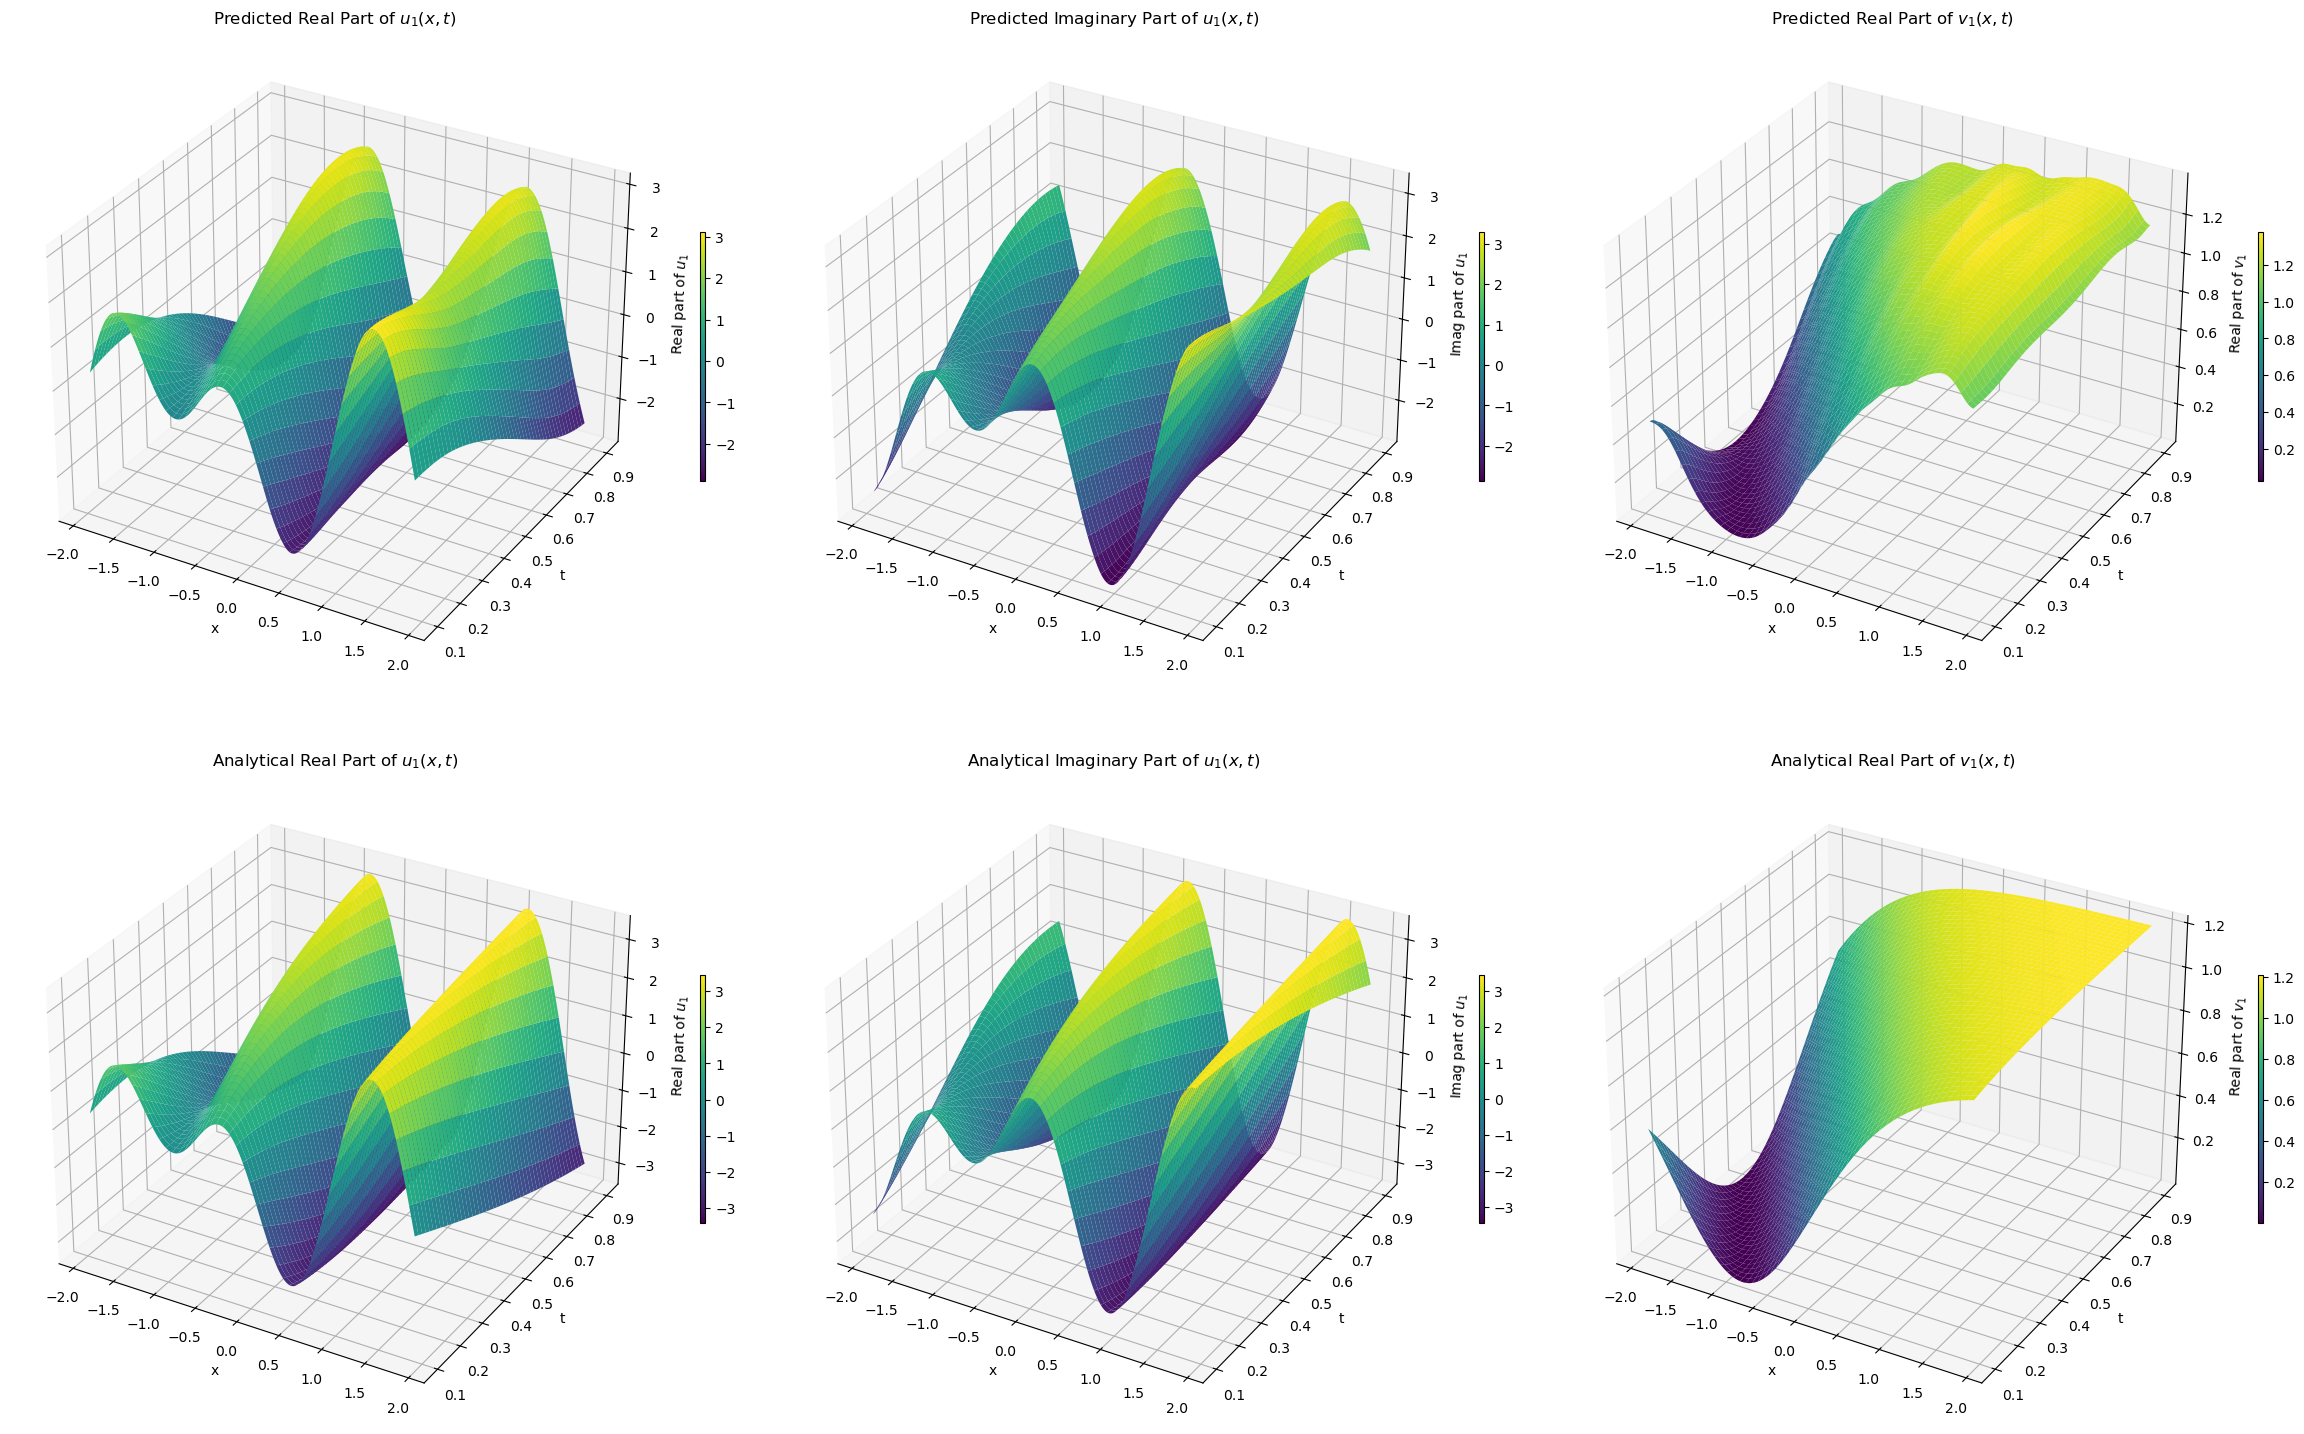

In [7]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_save_path = 'results' 
os.makedirs(image_save_path, exist_ok=True)

x = torch.linspace(-1.9, 1.9, 400)
t = torch.linspace(0.1, 0.9, 400)
X, T = torch.meshgrid(x, t)  # Create a 2D grid of x and t
X_flat = X.flatten().unsqueeze(-1).to(device)
T_flat = T.flatten().unsqueeze(-1).to(device)
epoch = 40
model_state = torch.load(os.path.join(model_save_path, f'C_HIGGS_second_training.pth'), map_location=device)
model = FourierFeatureNN(input_dim=1, shared_units=128, output_dim=3, layers_per_path=2, scale=1.0, 
                         activation=nn.Tanh, path_neurons=[128, 128, 128, 128], ffn_neurons=[128, 128, 128], device=device).to(device)
model.load_state_dict(model_state)
model.eval()

# Get predictions from the trained models
with torch.no_grad():
    pred_u_r, pred_u_i, pred_v = model(X_flat, T_flat) 

pred_u_r = pred_u_r.cpu().reshape(X.shape).numpy()
pred_u_i = pred_u_i.cpu().reshape(X.shape).numpy()
pred_v = pred_v.cpu().reshape(X.shape).numpy()

real_u1_analytical = real_u1(X_flat, T_flat, k, omega, r).cpu().reshape(X.shape).numpy()
imag_u1_analytical = imag_u1(X_flat, T_flat, k, omega, r).cpu().reshape(X.shape).numpy()
real_v1_analytical = real_v1(X_flat, T_flat, k, omega, r).cpu().reshape(X.shape).numpy()

sigma = 10  # This parameter controls the smoothness, adjust as needed
pred_v_smooth = gaussian_filter(pred_v, sigma=sigma)
shrink = 0.3
#cmap = 'gist_heat'
#cmap = 'turbo'
cmap = 'viridis'
aspect = 50

# Plotting predictions
fig = plt.figure(figsize=(24, 16))

# Plot predicted real part of u1
ax1 = fig.add_subplot(231, projection='3d')
surf1 = ax1.plot_surface(X.numpy(), T.numpy(), pred_u_r, cmap=cmap)
fig.colorbar(surf1, ax=ax1, shrink=shrink, aspect=aspect)
ax1.set_title('Predicted Real Part of $u_1(x, t)$')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('Real part of $u_1$')

# Plot predicted imaginary part of u1
ax2 = fig.add_subplot(232, projection='3d')
surf2 = ax2.plot_surface(X.numpy(), T.numpy(), pred_u_i, cmap=cmap)
fig.colorbar(surf2, ax=ax2, shrink=shrink, aspect=aspect)
ax2.set_title('Predicted Imaginary Part of $u_1(x, t)$')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('Imag part of $u_1$')

# Plot predicted real part of v1
ax3 = fig.add_subplot(233, projection='3d')
surf3 = ax3.plot_surface(X.numpy(), T.numpy(), pred_v_smooth, cmap=cmap)
fig.colorbar(surf3, ax=ax3, shrink=shrink, aspect=aspect)
ax3.set_title('Predicted Real Part of $v_1(x, t)$')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('Real part of $v_1$')

# Plot analytical real part of u1
ax1 = fig.add_subplot(234, projection='3d')
surf1 = ax1.plot_surface(X.numpy(), T.numpy(), real_u1_analytical, cmap=cmap)
fig.colorbar(surf1, ax=ax1, shrink=shrink, aspect=aspect)
ax1.set_title('Analytical Real Part of $u_1(x, t)$')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('Real part of $u_1$')

# Plot analytical imaginary part of u1
ax2 = fig.add_subplot(235, projection='3d')
surf2 = ax2.plot_surface(X.numpy(), T.numpy(), imag_u1_analytical, cmap=cmap)
fig.colorbar(surf2, ax=ax2, shrink=shrink, aspect=aspect)
ax2.set_title('Analytical Imaginary Part of $u_1(x, t)$')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('Imag part of $u_1$')

# Plot analytical real part of v1
ax3 = fig.add_subplot(236, projection='3d')
surf3 = ax3.plot_surface(X.numpy(), T.numpy(), real_v1_analytical, cmap=cmap)
fig.colorbar(surf3, ax=ax3, shrink=shrink, aspect=aspect)
ax3.set_title('Analytical Real Part of $v_1(x, t)$')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('Real part of $v_1$')

plt.tight_layout()
plt.savefig('results/chiggs_model_comparison_3d.png')
plt.show()

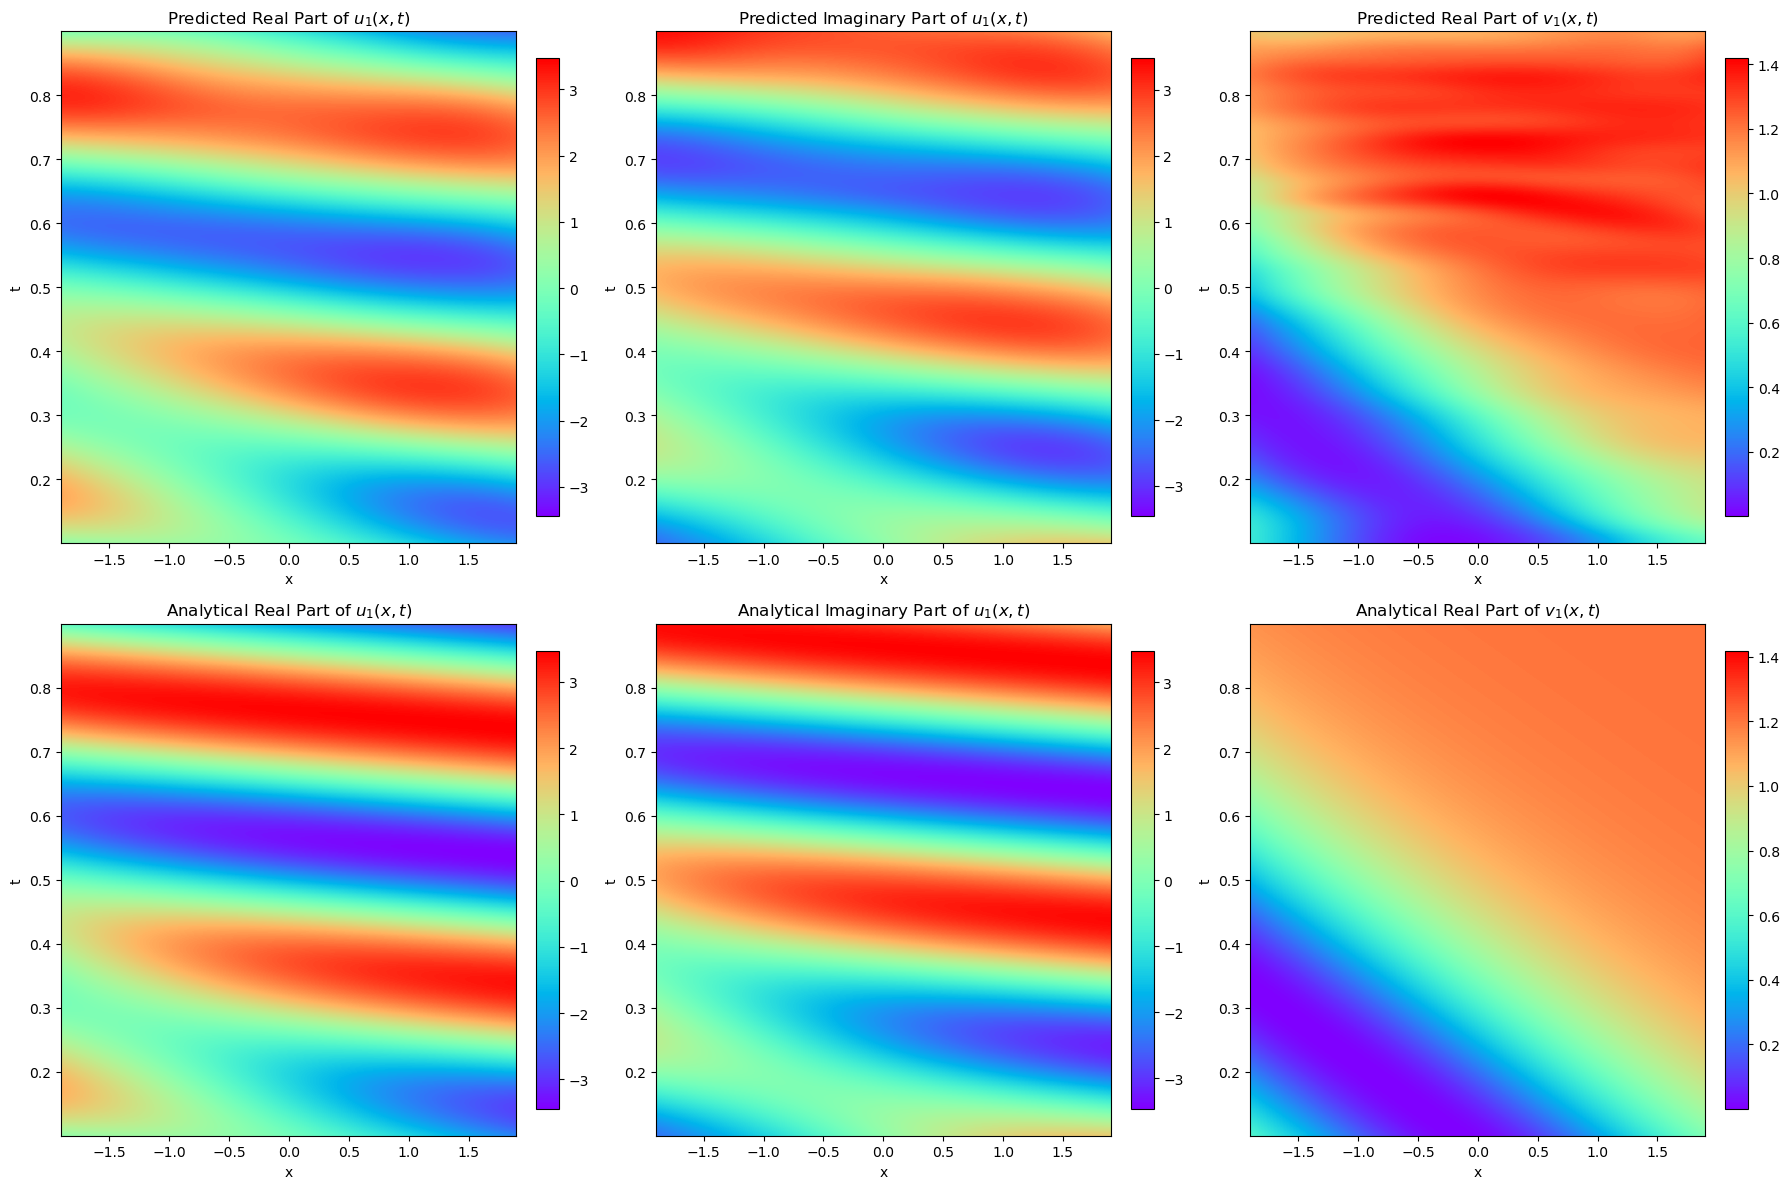

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

sigma = 5  # Controls the smoothness of pred_v
cmap = 'rainbow'  # Color map for the heatmaps
pred_v_smooth = gaussian_filter(pred_v, sigma=sigma)

# Calculate global min and max for each comparison column to standardize color scales
min_u_r = min(pred_u_r.min(), real_u1_analytical.min())
max_u_r = max(pred_u_r.max(), real_u1_analytical.max())

min_u_i = min(pred_u_i.min(), imag_u1_analytical.min())
max_u_i = max(pred_u_i.max(), imag_u1_analytical.max())

min_v = min(pred_v_smooth.min(), real_v1_analytical.min())
max_v = max(pred_v_smooth.max(), real_v1_analytical.max())

# Set up the figure for heatmaps
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # Adjust the figure size as needed

# Helper function to display a heatmap
def display_heatmap(ax, data, title, xlabel, ylabel, vmin, vmax):
    heatmap = ax.imshow(data, cmap=cmap, origin='lower', extent=[X.min(), X.max(), T.min(), T.max()], aspect='auto', vmin=vmin, vmax=vmax)
    fig.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# Displaying the heatmaps with standardized color scales
display_heatmap(axs[0, 0], pred_u_r, 'Predicted Real Part of $u_1(x, t)$', 'x', 't', min_u_r, max_u_r)
display_heatmap(axs[0, 1], pred_u_i, 'Predicted Imaginary Part of $u_1(x, t)$', 'x', 't', min_u_i, max_u_i)
display_heatmap(axs[0, 2], pred_v_smooth, 'Predicted Real Part of $v_1(x, t)$', 'x', 't', min_v, max_v)
display_heatmap(axs[1, 0], real_u1_analytical, 'Analytical Real Part of $u_1(x, t)$', 'x', 't', min_u_r, max_u_r)
display_heatmap(axs[1, 1], imag_u1_analytical, 'Analytical Imaginary Part of $u_1(x, t)$', 'x', 't', min_u_i, max_u_i)
display_heatmap(axs[1, 2], real_v1_analytical, 'Analytical Real Part of $v_1(x, t)$', 'x', 't', min_v, max_v)

plt.tight_layout()
plt.savefig('results/heatmaps_chiggs.png')
plt.show()
